In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0243_1.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0101_0.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0228_1.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0099_0.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0020_0.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0338_1.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0080_0.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0258_1.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0213_1.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0047_0.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0117_1.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0141_1.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0162_1.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0348_1.png.json
/kaggle/input/montgomery-tv/Montgomery/ann/MCUCXR_0375_1.png.json
/kaggle/in

3segmentation

In [70]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Input, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from sklearn.model_selection import train_test_split
import cv2
import os

In [71]:
# Attention Mechanisms
class PixelAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(PixelAttention, self).__init__(**kwargs)
        self.conv = Conv2D(1, kernel_size=1, activation='sigmoid')

    def call(self, inputs):
        attention = self.conv(inputs)
        return Multiply()([inputs, attention])

class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.conv = Conv2D(filters, kernel_size=1, activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        attention = self.conv(concat)
        return Multiply()([inputs, attention])

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        attention = self.conv(concat)
        return Multiply()([inputs, attention])

# Dice Coefficient
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-7)

def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

# U-Net Model with Attention
def improved_unet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    c1 = PixelAttention()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), padding='same', activation='relu')(p1)
    c2 = ChannelAttention(128)(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), padding='same', activation='relu')(p2)
    c3 = SpatialAttention()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c4 = Conv2D(512, (3, 3), padding='same', activation='relu')(p3)
    
    # Decoder
    u5 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c4)
    c5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, (3, 3), padding='same', activation='relu')(c5)
    
    u6 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c5)
    c6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, (3, 3), padding='same', activation='relu')(c6)
    
    u7 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c6)
    c7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, (3, 3), padding='same', activation='relu')(c7)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, iou_metric])
    return model


# #small unet
# def improved_unet(input_shape=(256, 256, 1)):
#     inputs = Input(input_shape)
    
#     # Encoder with reduced filters
#     c1 = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
#     p1 = MaxPooling2D((2, 2))(c1)
    
#     c2 = Conv2D(64, (3, 3), padding='same', activation='relu')(p1)
#     p2 = MaxPooling2D((2, 2))(c2)
    
#     c3 = Conv2D(128, (3, 3), padding='same', activation='relu')(p2)
#     p3 = MaxPooling2D((2, 2))(c3)
    
#     # Bottleneck
#     c4 = Conv2D(256, (3, 3), padding='same', activation='relu')(p3)
    
#     # Decoder with reduced filters
#     u5 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c4)
#     c5 = Concatenate()([u5, c3])
#     c5 = Conv2D(128, (3, 3), padding='same', activation='relu')(c5)
    
#     u6 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c5)
#     c6 = Concatenate()([u6, c2])
#     c6 = Conv2D(64, (3, 3), padding='same', activation='relu')(c6)
    
#     u7 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c6)
#     c7 = Concatenate()([u7, c1])
#     c7 = Conv2D(32, (3, 3), padding='same', activation='relu')(c7)
    
#     outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model


In [72]:

# Load datasets
def load_images(image_path, mask_path):
    images, masks = [], []
    for filename in os.listdir(image_path):
        img_file = os.path.join(image_path, filename)
        mask_file = os.path.join(mask_path, filename)
        if os.path.exists(mask_file):
            image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            if image is not None and mask is not None:
                images.append(np.expand_dims(cv2.resize(image, (256, 256)) / 255.0, axis=-1))
                masks.append(np.expand_dims(cv2.resize(mask, (256, 256)) / 255.0, axis=-1))
    return np.array(images), np.array(masks)

montgomery_images, montgomery_masks = load_images('/kaggle/input/montgomery-tv/Montgomery/img', '/kaggle/input/montgomery-tv/Montgomery/mask')
shenzhen_images, shenzhen_masks = load_images('/kaggle/input/shenzen-tb/Shenzhen/img', '/kaggle/input/shenzen-tb/Shenzhen/mask')

X = np.concatenate([montgomery_images, shenzhen_images])
Y = np.concatenate([montgomery_masks, shenzhen_masks])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [73]:
model = improved_unet()
model.fit(X_train, Y_train, epochs=35, batch_size=8, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 311ms/step - accuracy: 0.7077 - dice_coefficient: 0.3101 - iou_metric: 0.1841 - loss: 0.6377 - val_accuracy: 0.7366 - val_dice_coefficient: 0.2777 - val_iou_metric: 0.1613 - val_loss: 0.5313
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.7531 - dice_coefficient: 0.3475 - iou_metric: 0.2141 - loss: 0.4539 - val_accuracy: 0.8450 - val_dice_coefficient: 0.6944 - val_iou_metric: 0.5326 - val_loss: 0.3599
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.9043 - dice_coefficient: 0.7231 - iou_metric: 0.5682 - loss: 0.2305 - val_accuracy: 0.9157 - val_dice_coefficient: 0.7616 - val_iou_metric: 0.6160 - val_loss: 0.2103
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.9188 - dice_coefficient: 0.7689 - iou_metric: 0.6256 - loss: 0.1967 - val_accuracy: 0.9146 - val_dice_coefficient: 0.7950 - val_iou_metric: 0.6605 - val_loss: 0.2220
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.

In [ ]:
import tensorflow as tf

# Assuming 'model' is your trained model
model.save_weights('model_weights.h5')  # Saves weights in .h5 format


In [74]:
# output_dir = 'segmented_outputs'
# os.makedirs(output_dir, exist_ok=True)

In [75]:
# # Predictions and saving images
# predictions = model.predict(X_test)
# predictions_binary = (predictions > 0.5).astype(np.uint8)

# for i in range(len(X_test)):
#     filename = os.path.join(output_dir, f'segmented_{i}.png')
#     plt.imsave(filename, predictions_binary[i, :, :, 0], cmap='gray')

# # Display only 5 saved images
# plt.figure(figsize=(15, 5))
# for i in range(5):
#     plt.subplot(1, 5, i+1)
#     plt.imshow(predictions_binary[i, :, :, 0], cmap='gray')
#     plt.title(f'Segmented {i}')
#     plt.axis('off')
# plt.show()

In [76]:
import os
from PIL import Image
import matplotlib.pyplot as plt


In [77]:
# Define the paths for to load tawsifur dataset
tuberculosis_path = '/kaggle/input/tb-tawsifur/TB_Chest_Radiography_Database/Tuberculosis'
normal_path = '/kaggle/input/tb-tawsifur/TB_Chest_Radiography_Database/Normal'

In [78]:
# Define directory paths
predicted_image_to_input_path_normal_img = 'predicted_image_to_input_normal_img'
predicted_image_to_input_path_tuberculosis_img = 'predicted_image_to_input_tuberculosis_img'
predicted_image_to_input_path_normal_mask = 'predicted_image_to_input_normal_mask'
predicted_image_to_input_path_tuberculosis_mask = 'predicted_image_to_input_tuberculosis_mask'

# Ensure directories exist BEFORE saving images
os.makedirs(predicted_image_to_input_path_normal_img, exist_ok=True)
os.makedirs(predicted_image_to_input_path_tuberculosis_img, exist_ok=True)
os.makedirs(predicted_image_to_input_path_normal_mask, exist_ok=True)
os.makedirs(predicted_image_to_input_path_tuberculosis_mask, exist_ok=True)

In [79]:
#load image from tawsifur dataset
def load_images_from_directory(directory_path):
    images = []
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                images.append(np.expand_dims(cv2.resize(image, (256, 256)) / 255.0, axis=-1))
    return np.array(images)

In [80]:
# Load the images from both directories
tuberculosis_images = load_images_from_directory(tuberculosis_path)
normal_images = load_images_from_directory(normal_path)

In [81]:
tuberculosis_images.shape

(700, 256, 256, 1)

In [82]:
normal_images.shape

(3500, 256, 256, 1)

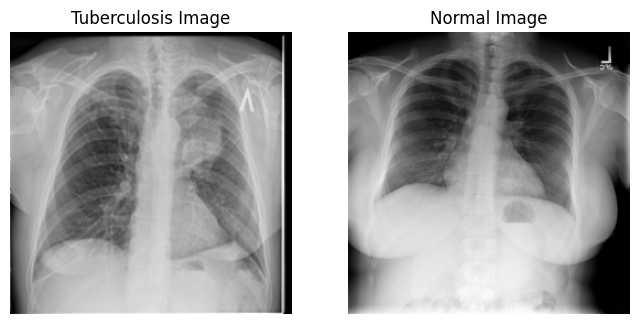

In [83]:


# Ensure there are images before accessing index 4
if tuberculosis_images.shape[0] > 4 and normal_images.shape[0] > 4:
    # Extract the 5th image (index 4) and remove the extra dimension
    tb_image = tuberculosis_images[4, :, :, 0]  # Shape (256, 256)
    normal_image = normal_images[4, :, :, 0]  # Shape (256, 256)

    # Display the images
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(tb_image, cmap="gray")  # Grayscale image
    plt.title("Tuberculosis Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(normal_image, cmap="gray")
    plt.title("Normal Image")
    plt.axis('off')

    plt.show()

else:
    print("No images found or not enough images in one or both directories.")



# **dataset is imbalance , take required measure to counter this limit normal image to input , data augumentation all that**


In [84]:
# Just to  Limit the number of normal images to match the number of tuberculosis images
num_images = min(len(tuberculosis_images), len(normal_images))
normal_images = normal_images[:num_images]


In [85]:
# Predictions and saving images
predictions = model.predict(tuberculosis_images)

print("Total Predication on Tuberculosis images", len(predictions))

predictions_binary = (predictions > 0).astype(np.uint8)

# Save both original and predicted images
for i in range(len(tuberculosis_images)):
    # Save the original image
    original_filename = os.path.join(predicted_image_to_input_path_tuberculosis_img, f'original_{i}.png')
    plt.imsave(original_filename, tuberculosis_images[i, :, :, 0], cmap='gray')  # assuming grayscale images for simplicity

    # Save the predicted image
    predicted_filename = os.path.join(predicted_image_to_input_path_tuberculosis_mask, f'predicted_{i}.png')
    plt.imsave(predicted_filename, predictions_binary[i, :, :, 0], cmap='gray')


22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 652ms/step
Total Predication on Tuberculosis images 700


In [86]:

# Predictions and saving images
predictions = model.predict(normal_images)
print("Total Predication on normal images", len(predictions))
predictions_binary = (predictions > 0).astype(np.uint8)
print("Total Predication on normal images prediction binary", len(predictions_binary))
# Save both original and predicted images
for i in range(len(normal_images)):
    # Save the original image
    original_filename = os.path.join(predicted_image_to_input_path_normal_img, f'original_{i}.png')
    plt.imsave(original_filename, normal_images[i, :, :, 0], cmap='gray')  # assuming grayscale images for simplicity

    # Save the predicted image
    predicted_filename = os.path.join(predicted_image_to_input_path_normal_mask, f'predicted_{i}.png')
    plt.imsave(predicted_filename, predictions_binary[i, :, :, 0], cmap='gray')


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step
Total Predication on normal images 700
Total Predication on normal images prediction binary 700


#classification

In [87]:
!pip install timm
import torch
import torchvision.models as models
import timm  # For SENet

# Load GoogleNet (Inception v1)
googlenet = models.googlenet(pretrained=True)

# Load ResNet-50
resnet = models.resnet50(pretrained=True)

# Load SENet-154 from timm
senet = timm.create_model('senet154', pretrained=True)

# Print model summaries (optional)
print(googlenet)
print(resnet)
print(senet)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date we

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [88]:
import tensorflow as tf
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from glob import glob
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, ResNet50, DenseNet121
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Image size and data directories
image_size = (256, 256)
batch_size = 32
num_classes = 2

# Update your image and mask paths
normal_image_dir = "/kaggle/working/predicted_image_to_input_normal_img/"
normal_mask_dir = "/kaggle/working/predicted_image_to_input_normal_mask/"
tb_image_dir = "/kaggle/working/predicted_image_to_input_tuberculosis_img/"
tb_mask_dir = "/kaggle/working/predicted_image_to_input_tuberculosis_mask/"

# Update glob to match the specific files you're working with
normal_image_paths = glob(os.path.join(normal_image_dir, "*.png"))  # Match .png files
normal_mask_paths = glob(os.path.join(normal_mask_dir, "*.png"))

tb_image_paths = glob(os.path.join(tb_image_dir, "*.png"))
tb_mask_paths = glob(os.path.join(tb_mask_dir, "*.png"))

# Print out the number of images found to verify glob is working correctly
print(f"Normal images: {len(normal_image_paths)}")
print(f"Normal masks: {len(normal_mask_paths)}")
print(f"TB images: {len(tb_image_paths)}")
print(f"TB masks: {len(tb_mask_paths)}")

# Ensure all paths are correctly captured
print(f"Sample normal image path: {normal_image_paths[:2]}")  # Print the first 2 normal image paths
print(f"Sample TB image path: {tb_image_paths[:2]}")  # Print the first 2 TB image paths

# If everything looks good, proceed with concatenating the lists
image_paths = normal_image_paths + tb_image_paths
mask_paths = normal_mask_paths + tb_mask_paths

# Generate labels based on paths: 0 for normal images, 1 for TB images
y = np.concatenate([np.zeros(len(normal_image_paths), dtype=np.uint8), np.ones(len(tb_image_paths), dtype=np.uint8)])

# Shuffle the data and split into training and validation
image_paths_train, image_paths_val, mask_paths_train, mask_paths_val, y_train, y_val = train_test_split(image_paths, mask_paths, y, test_size=0.2, random_state=42)

# Check the split
print(f"Training data size: {len(image_paths_train)}")
print(f"Validation data size: {len(image_paths_val)}")



Normal images: 700
Normal masks: 700
TB images: 700
TB masks: 700
Sample normal image path: ['/kaggle/working/predicted_image_to_input_normal_img/original_467.png', '/kaggle/working/predicted_image_to_input_normal_img/original_615.png']
Sample TB image path: ['/kaggle/working/predicted_image_to_input_tuberculosis_img/original_467.png', '/kaggle/working/predicted_image_to_input_tuberculosis_img/original_615.png']
Training data size: 1120
Validation data size: 280


In [89]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import InceptionV3, ResNet50, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# CombinedImageMaskGenerator (unchanged)
class CombinedImageMaskGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, image_size, labels, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.labels = labels
        self.shuffle = shuffle
        self.indexes = np.arange(len(image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[i] for i in batch_indexes]
        batch_mask_paths = [self.mask_paths[i] for i in batch_indexes]
        
        images = []
        labels = []

        for i, (img_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read RGB image
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale mask
            
            image = cv2.resize(image, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            image = image / 255.0  # Normalize the RGB image
            mask = mask / 255.0  # Normalize the mask (grayscale)

            mask_3d = np.expand_dims(mask, axis=-1)  # Expand mask to 3D shape for multiplication
            combined_input = image * mask_3d  # Superimpose (element-wise multiplication)

            images.append(combined_input)
            
            labels.append(self.labels[batch_indexes[i]])
        
        return np.array(images), np.array(labels)

# Initialize generators for training and validation
train_generator = CombinedImageMaskGenerator(image_paths=image_paths_train,
                                             mask_paths=mask_paths_train,
                                             batch_size=batch_size, 
                                             image_size=image_size,
                                             labels=y_train)

val_generator = CombinedImageMaskGenerator(image_paths=image_paths_val,
                                           mask_paths=mask_paths_val,
                                           batch_size=batch_size, 
                                           image_size=image_size,
                                           labels=y_val)

# Define base models (e.g., InceptionV3, ResNet50, DenseNet121) for classification
input_layer = Input(shape=(image_size[0], image_size[1], 3))  # 3 channels (RGB + superimposed mask)

# InceptionV3 Model
googlenet_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_layer)
googlenet_output = GlobalAveragePooling2D()(googlenet_base.output)
googlenet_output = Dense(num_classes, activation='softmax')(googlenet_output)
googlenet_model = Model(inputs=input_layer, outputs=googlenet_output)

# ResNet50 Model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)
resnet_output = GlobalAveragePooling2D()(resnet_base.output)
resnet_output = Dense(num_classes, activation='softmax')(resnet_output)
resnet_model = Model(inputs=input_layer, outputs=resnet_output)

# DenseNet121 Model
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_layer)
densenet_output = GlobalAveragePooling2D()(densenet_base.output)
densenet_output = Dense(num_classes, activation='softmax')(densenet_output)
densenet_model = Model(inputs=input_layer, outputs=densenet_output)

# Compile models
for model in [googlenet_model, resnet_model, densenet_model]:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

# Train models
googlenet_model.fit(train_generator, validation_data=val_generator, epochs=30, verbose=1)
resnet_model.fit(train_generator, validation_data=val_generator, epochs=30, verbose=1)
densenet_model.fit(train_generator, validation_data=val_generator, epochs=30, verbose=1)

# Confusion matrix function
def plot_confusion_matrix(model, data_generator, model_name):
    y_true = []
    y_pred = []
    
    for x_batch, y_batch in data_generator:
        y_true.extend(y_batch)
        preds = model.predict(x_batch)
        y_pred.extend(np.argmax(preds, axis=1))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(data_generator.class_indices.keys()), yticklabels=list(data_generator.class_indices.keys()))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix(googlenet_model, val_generator, "InceptionV3")
plot_confusion_matrix(resnet_model, val_generator, "ResNet50")
plot_confusion_matrix(densenet_model, val_generator, "DenseNet121")

# Majority Voting Ensemble
def max_voting_ensemble(models, data_generator):
    predictions = []
    
    for x_batch, _ in data_generator:
        batch_preds = np.array([model.predict(x_batch) for model in models])
        avg_batch_preds = np.mean(batch_preds, axis=0)
        ensemble_pred = np.argmax(avg_batch_preds, axis=1)
        predictions.extend(ensemble_pred)
    
    return np.array(predictions)

# Generate ensemble predictions
ensemble_predictions = max_voting_ensemble([googlenet_model, resnet_model, densenet_model], val_generator)

# Confusion matrix for ensemble predictions
y_true = y_val
ensemble_conf_matrix = confusion_matrix(y_true, ensemble_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(val_generator.class_indices.keys()), yticklabels=list(val_generator.class_indices.keys()))
plt.title("Confusion Matrix - Ensemble Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Evaluate ensemble predictions
ensemble_accuracy = np.mean(ensemble_predictions == y_true)
print("Ensemble Accuracy: ", ensemble_accuracy)

# Print classification report for ensemble
print("Ensemble Classification Report:\n", classification_report(y_true, ensemble_predictions, target_names=list(val_generator.class_indices.keys())))


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 88s 432ms/step - accuracy: 0.7371 - loss: 0.4753 - val_accuracy: 0.7852 - val_loss: 0.5939
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.9555 - loss: 0.1124 - val_accuracy: 0.9336 - val_loss: 0.1996
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - accuracy: 0.9494 - loss: 0.1086 - val_accuracy: 0.9648 - val_loss: 0.1213
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.9523 - loss: 0.0835 - val_accuracy: 0.9688 - val_loss: 0.0935
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.9650 - loss: 0.0782 - val_accuracy: 0.9688 - val_loss: 0.0893
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - accuracy: 0.9595 - loss: 0.0985 - val_accuracy: 0.9688 - val_loss: 0.1021
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.9468 - loss: 0.1045 - val_accuracy: 0.8086 - val_loss: 0.4881
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.9525 - loss: 0.1018 - val_accuracy: 0.921

ValueError: operands could not be broadcast together with shapes (256,) (280,) 

In [ ]:

# Metrics calculation
accuracy = accuracy_score(y_true, ensemble_predictions)
precision = precision_score(y_true, ensemble_predictions, average='weighted')
recall = recall_score(y_true, ensemble_predictions, average='weighted')
f1 = f1_score(y_true, ensemble_predictions, average='weighted')

print(f"Ensemble Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, ensemble_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display individual predictions with confidence scores
class_labels = ['Normal', 'Tuberculosis']

def predict_and_display(data, predictions, scores, num_samples=10):
    for i in range(num_samples):
        img, label = data[i]
        pred_class = class_labels[predictions[i]]
        pred_score = np.max(scores[i]) * 100  # Get highest probability
        actual_class = class_labels[label]
        print(f"Actual: {actual_class}, Predicted: {pred_class}, Confidence: {pred_score:.2f}%")

# Show some predictions
predict_and_display(val_generator, ensemble_predictions, ensemble_scores)


In [90]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
ensemble_model.fit(train_data, validation_data=val_data, epochs=30, verbose=1, callbacks=[early_stopping, lr_scheduler])

# Evaluate model
y_pred = np.argmax(ensemble_model.predict(val_data), axis=1)
y_true = val_data.classes

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Cohen Kappa Score: {kappa:.2f}")
print(f"Matthews Correlation Coefficient: {mcc:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=list(val_data.class_indices.keys())))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(val_data.class_indices.keys()), yticklabels=list(val_data.class_indices.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# # Predict on a user-provided image
# def predict_user_image(model, image_path):
#     image = load_img(image_path, target_size=image_size)
#     image_array = img_to_array(image) / 255.0
#     image_array = np.expand_dims(image_array, axis=0)
    
#     prediction = np.argmax(model.predict(image_array))
#     class_labels = list(val_data.class_indices.keys())
    
#     plt.imshow(image)
#     plt.title(f"Prediction: {class_labels[prediction]}")
#     plt.axis('off')
#     plt.show()
    
#     print(f"Prediction: {class_labels[prediction]}")

# # Take input from the user
# user_image_path = input("Enter the path of the image to predict: ")
# predict_user_image(ensemble_model, user_image_path)

NameError: name 'y_pred' is not defined